In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import xmltodict, json
from simulation import DefaultCIR, ConstPossionJumpsCIR, NormalPossionJumpsCIR
import numpy as np

https://www.moex.com/ru/factsheet/history

In [3]:
rusfar = pd.read_csv('data/RUSFAR_2019-01-01__2024-01-01.csv', delimiter=';')
rusfar = rusfar.drop(columns=['ID', 'NAME', 'OPEN', 'HIGH', 'LOW', 'VALUE', 'DURATION', 'YIELD'])
rusfar = rusfar.rename(columns={'TRADEDATE': 'date', 'CLOSE': 'rub_rate'})
rusfar['rub_rate'] = rusfar['rub_rate'].str.replace(',', '.').astype(float)
rusfar['date'] = pd.to_datetime(rusfar['date'])
rusfar = rusfar.sort_values('date').set_index('date')
rusfar.head(2)

rub_rate
date                
2019-01-09      7.71
2019-01-10      7.68

https://fred.stlouisfed.org/series/SOFR

In [4]:
sofr = pd.read_csv('data/SOFR_2019-01-01__2024-01-01.csv')
sofr = sofr.rename(columns={'DATE': 'date', 'SOFR': 'usd_rate'})
sofr = sofr[sofr['usd_rate'] != '.'] # strange value at the end
sofr['usd_rate'] = sofr['usd_rate'].astype(float)
sofr['date'] = pd.to_datetime(sofr['date'])
sofr = sofr.sort_values('date').set_index('date')
sofr.head(2)

usd_rate
date                
2019-01-02      3.15
2019-01-03      2.70

https://www.moex.com/ru/derivatives/currency-rate.aspx?currency=USD_RUB#

In [5]:
with open('data/USD_RUB_2019-01-01__2024-01-01.xml', 'r') as f:
    usdrub = pd.DataFrame(xmltodict.parse(f.read())['document']['data']['rows']['row'])
# there are 2 values (morning and evening) per day, remain only evening
usdrub = usdrub[usdrub['@clearing']=='vk'].drop(columns=['@tradetime', '@secid', '@clearing'])
usdrub = usdrub.rename(columns={'@tradedate': 'date', '@rate': 'fx'})
usdrub['fx'] = usdrub['fx'].astype(float)
usdrub['date'] = pd.to_datetime(usdrub['date'])
usdrub = usdrub.sort_values('date').set_index('date')
usdrub.head(2)

fx
date               
2019-01-03  68.8620
2019-01-04  67.8181

In [6]:
data = pd.concat([
    rusfar, sofr, usdrub,
], axis=1).bfill().ffill() # Протягиваем значение на случай пропуска
data.head()

rub_rate  usd_rate       fx
date                                   
2019-01-02      7.71      3.15  68.8620
2019-01-03      7.71      2.70  68.8620
2019-01-04      7.71      2.45  67.8181
2019-01-07      7.71      2.41  66.9909
2019-01-08      7.71      2.42  66.9909

In [8]:
from simulation import (
    BaselineRangeAccrualPricingStrategy,
)

In [79]:
ra_config = {
    'contract_start': '2021-12-10',
    'contract_end': '2021-12-31',
    'upper_bound': 80,
    'lower_bound': 30,
    'notional': 1000,
    # 'notional_payoff': 1
}
data = data[
    data.index < pd.Timestamp(ra_config['contract_start'])
]
r_dom_history = data['rub_rate'].to_numpy()
r_for_history = data['usd_rate'].to_numpy()
fx_history = data['fx'].to_numpy()
simulation_config = {
    'r_dom_history': r_dom_history,
    'r_for_history': r_for_history,
    'fx_history': fx_history,
    'n_paths': 100,
    'dt': 1/252,
}
ra_model = BaselineRangeAccrualPricingStrategy(
    simulation_config=simulation_config,
    ra_config=ra_config
)

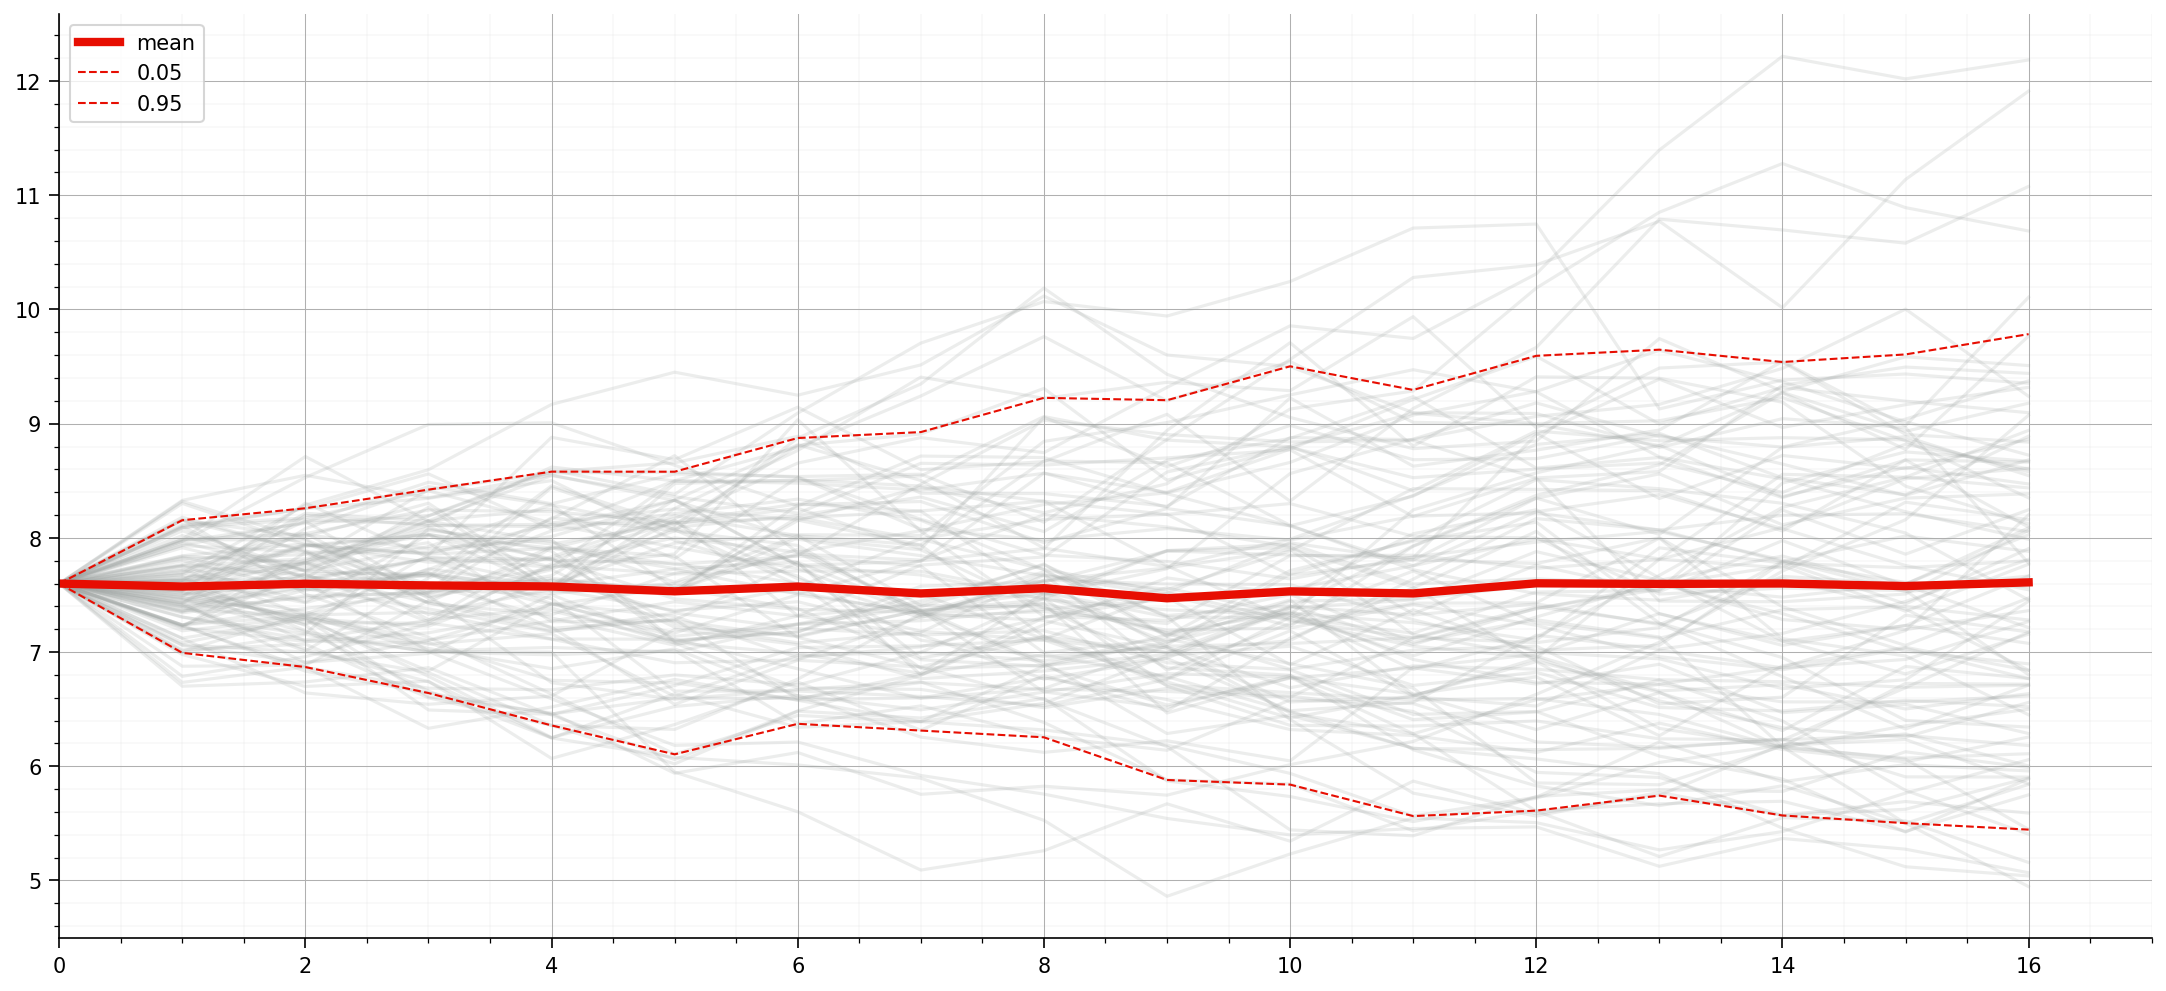

In [69]:
ra_model.r_for_model.plot_paths(ra_model.r_dom)

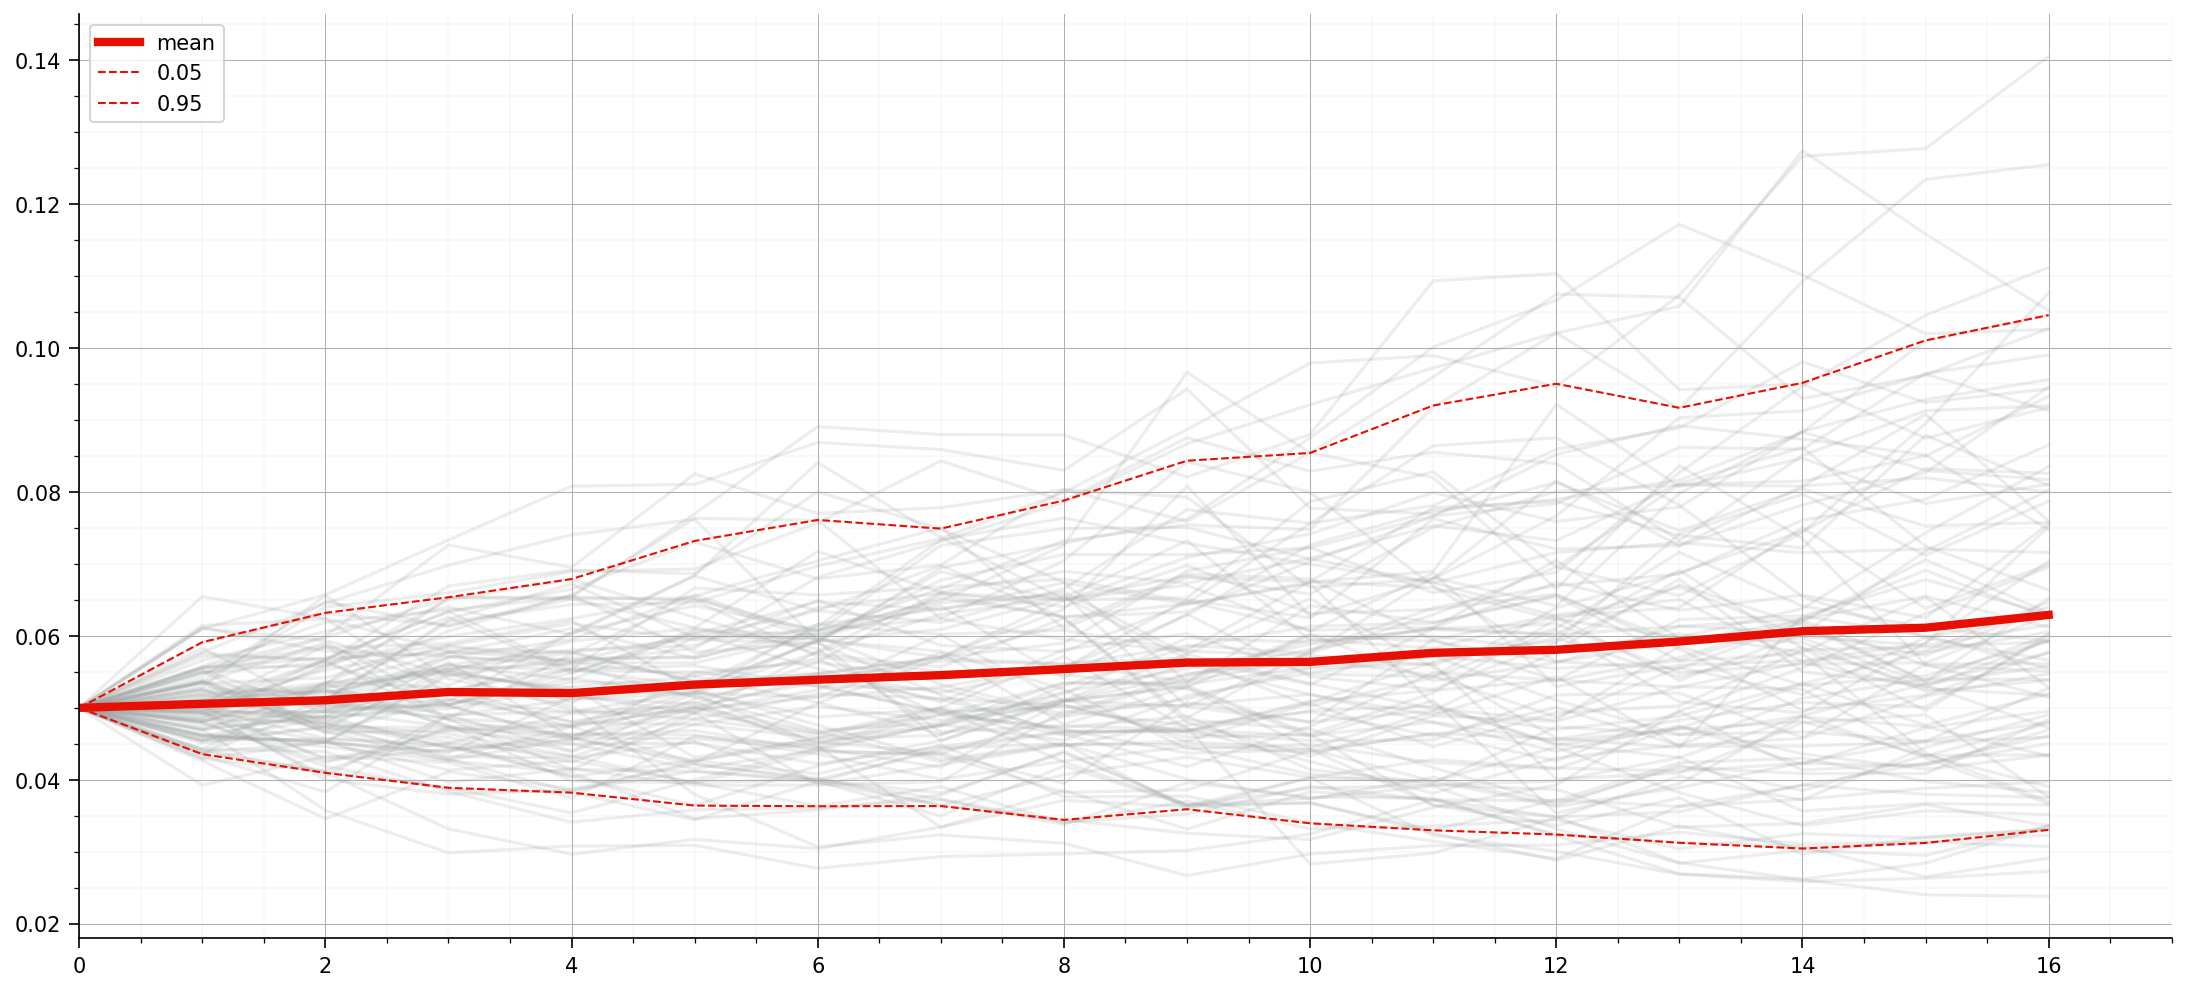

In [68]:
ra_model.r_for_model.plot_paths(ra_model.r_for)

In [71]:
FXSimulationModel(sigma=0.05)

NameError: name 'FXSimulationModel' is not defined

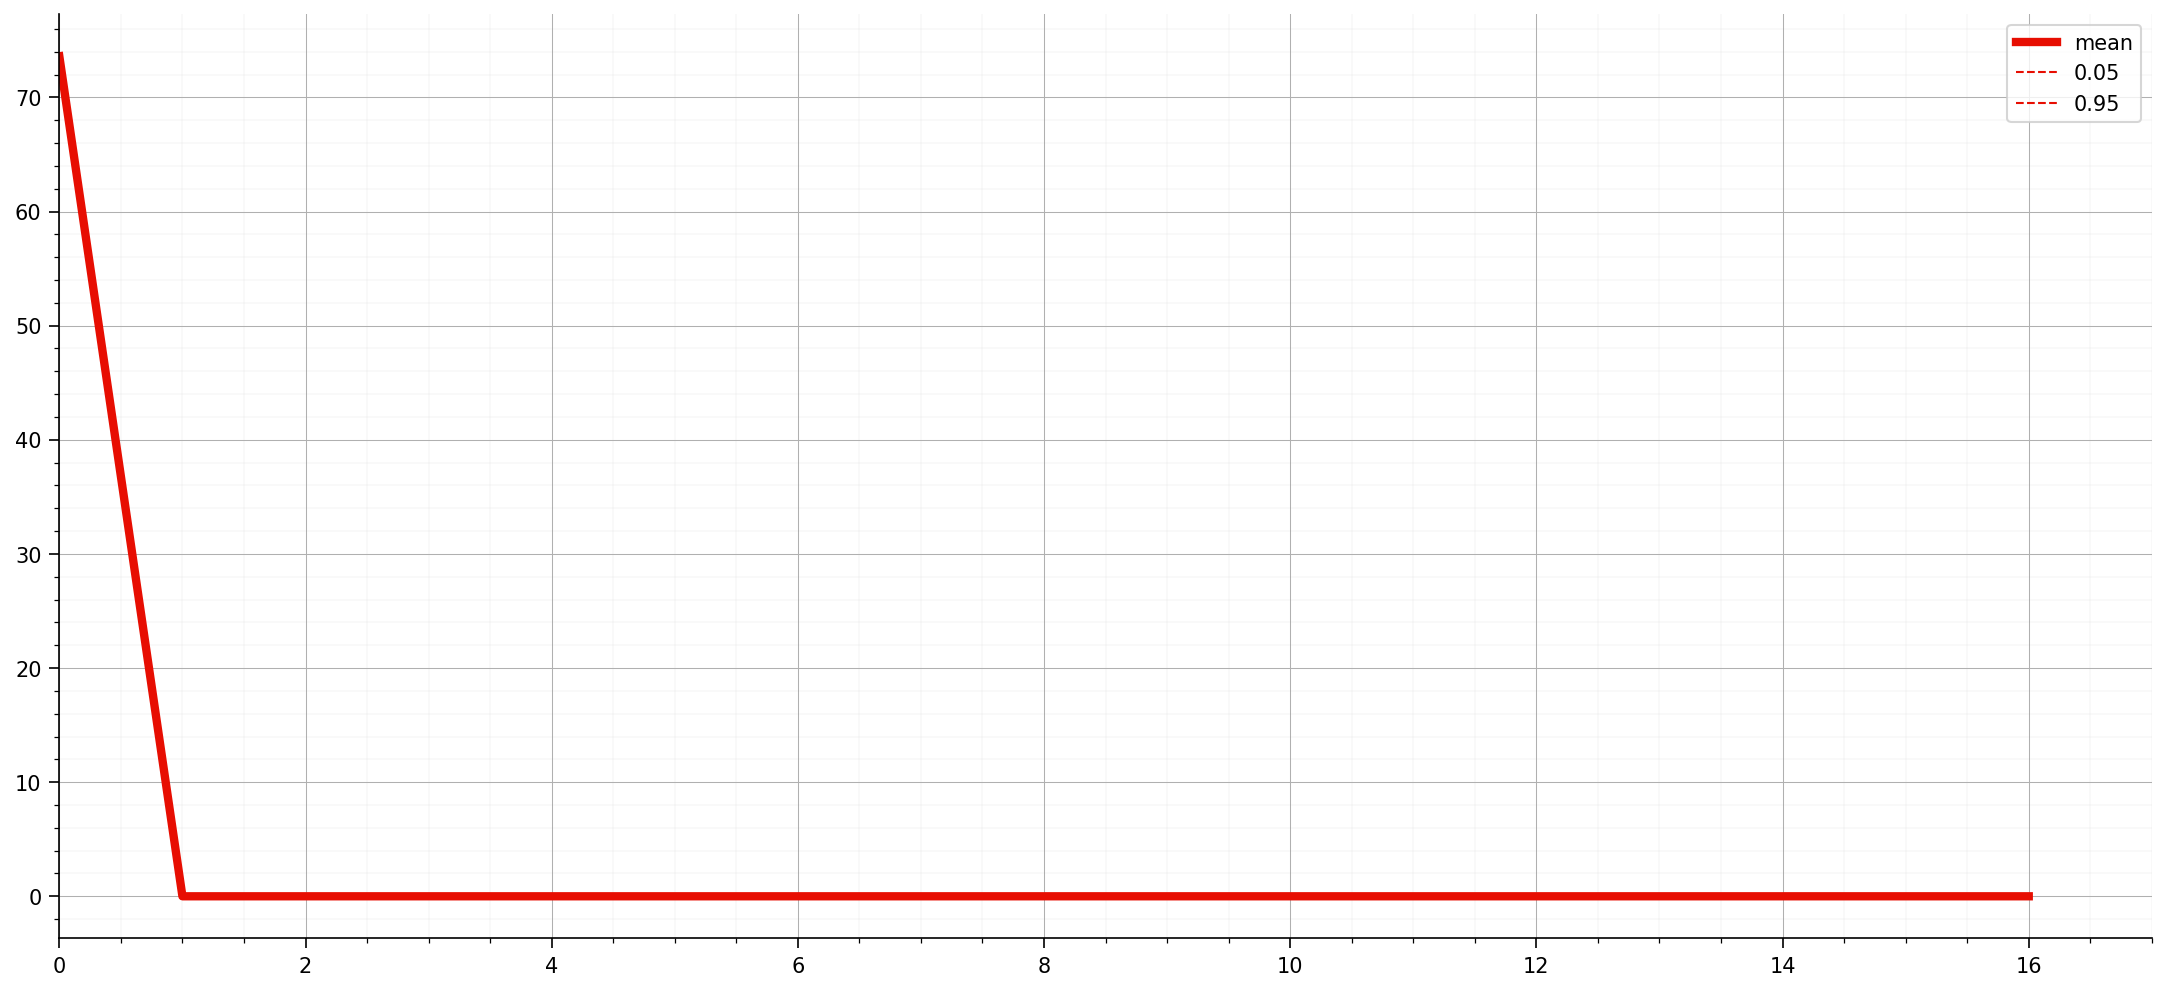

In [81]:
ra_model.r_for_model.plot_paths(ra_model.fx)

In [ ]:
self.fx_model

In [80]:
ra_model.get_simulation_results()

1000.0

In [45]:
ra_model.model_params

{'poisson_const_params': {'jump_size': 0.011315789473684145,
  'lambda_jump': 0.04967320261437908},
 'cir_dom_params': {'alpha': 0.00426490304524073,
  'theta': 5.866520377706203,
  'sigma': 0.048819477357692334},
 'cir_for_params': {'alpha': 0.005920223797959194,
  'theta': 0.1986550934174182,
  'sigma': 0.10178678557899551},
 'fx_params': {'sigma': 0.011964429014485361}}

In [46]:
ra_model.fx.max().max()

311652595319.0862

(0.0, 100.0)

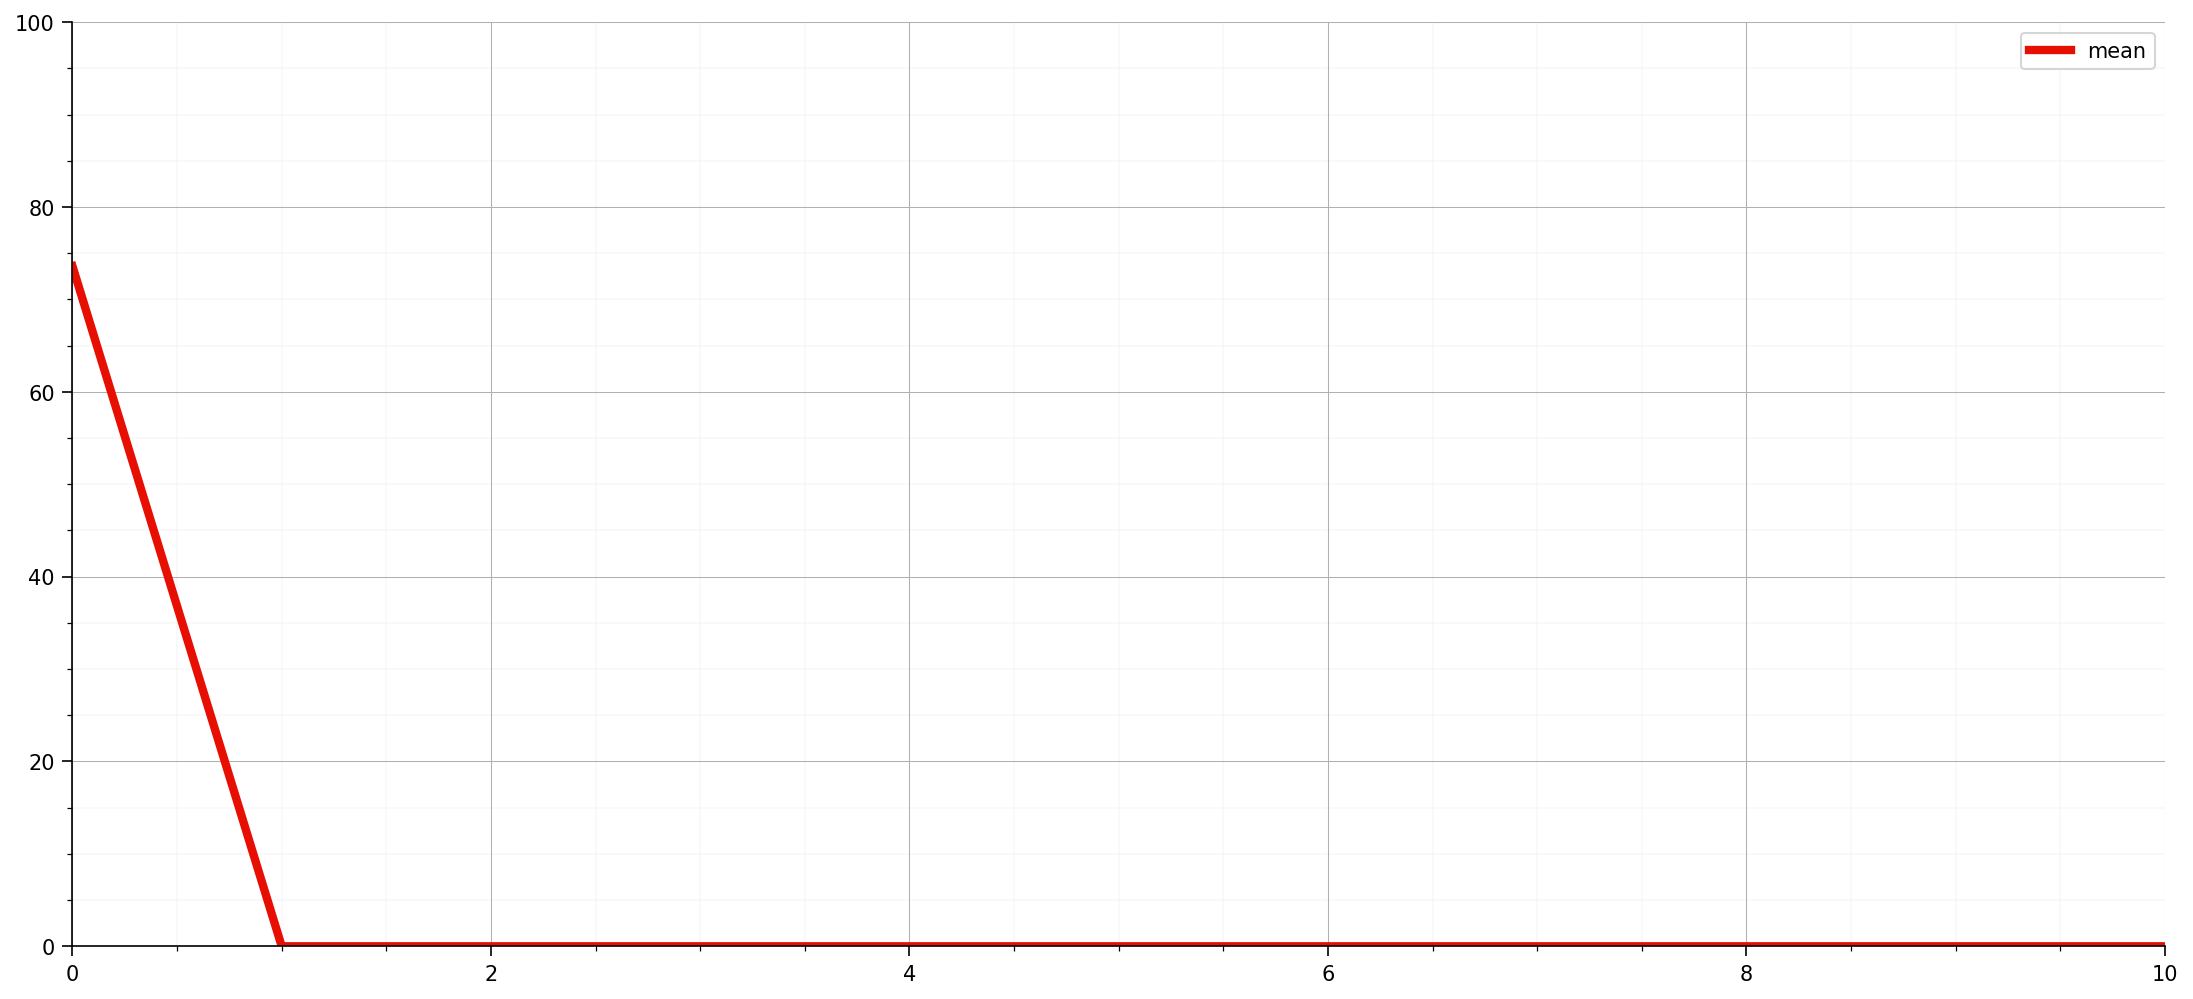

In [74]:
ax = ra_model.plot_range_w_paths()
ax.set_xlim(0, 10)
ax.set_ylim(0, 100)

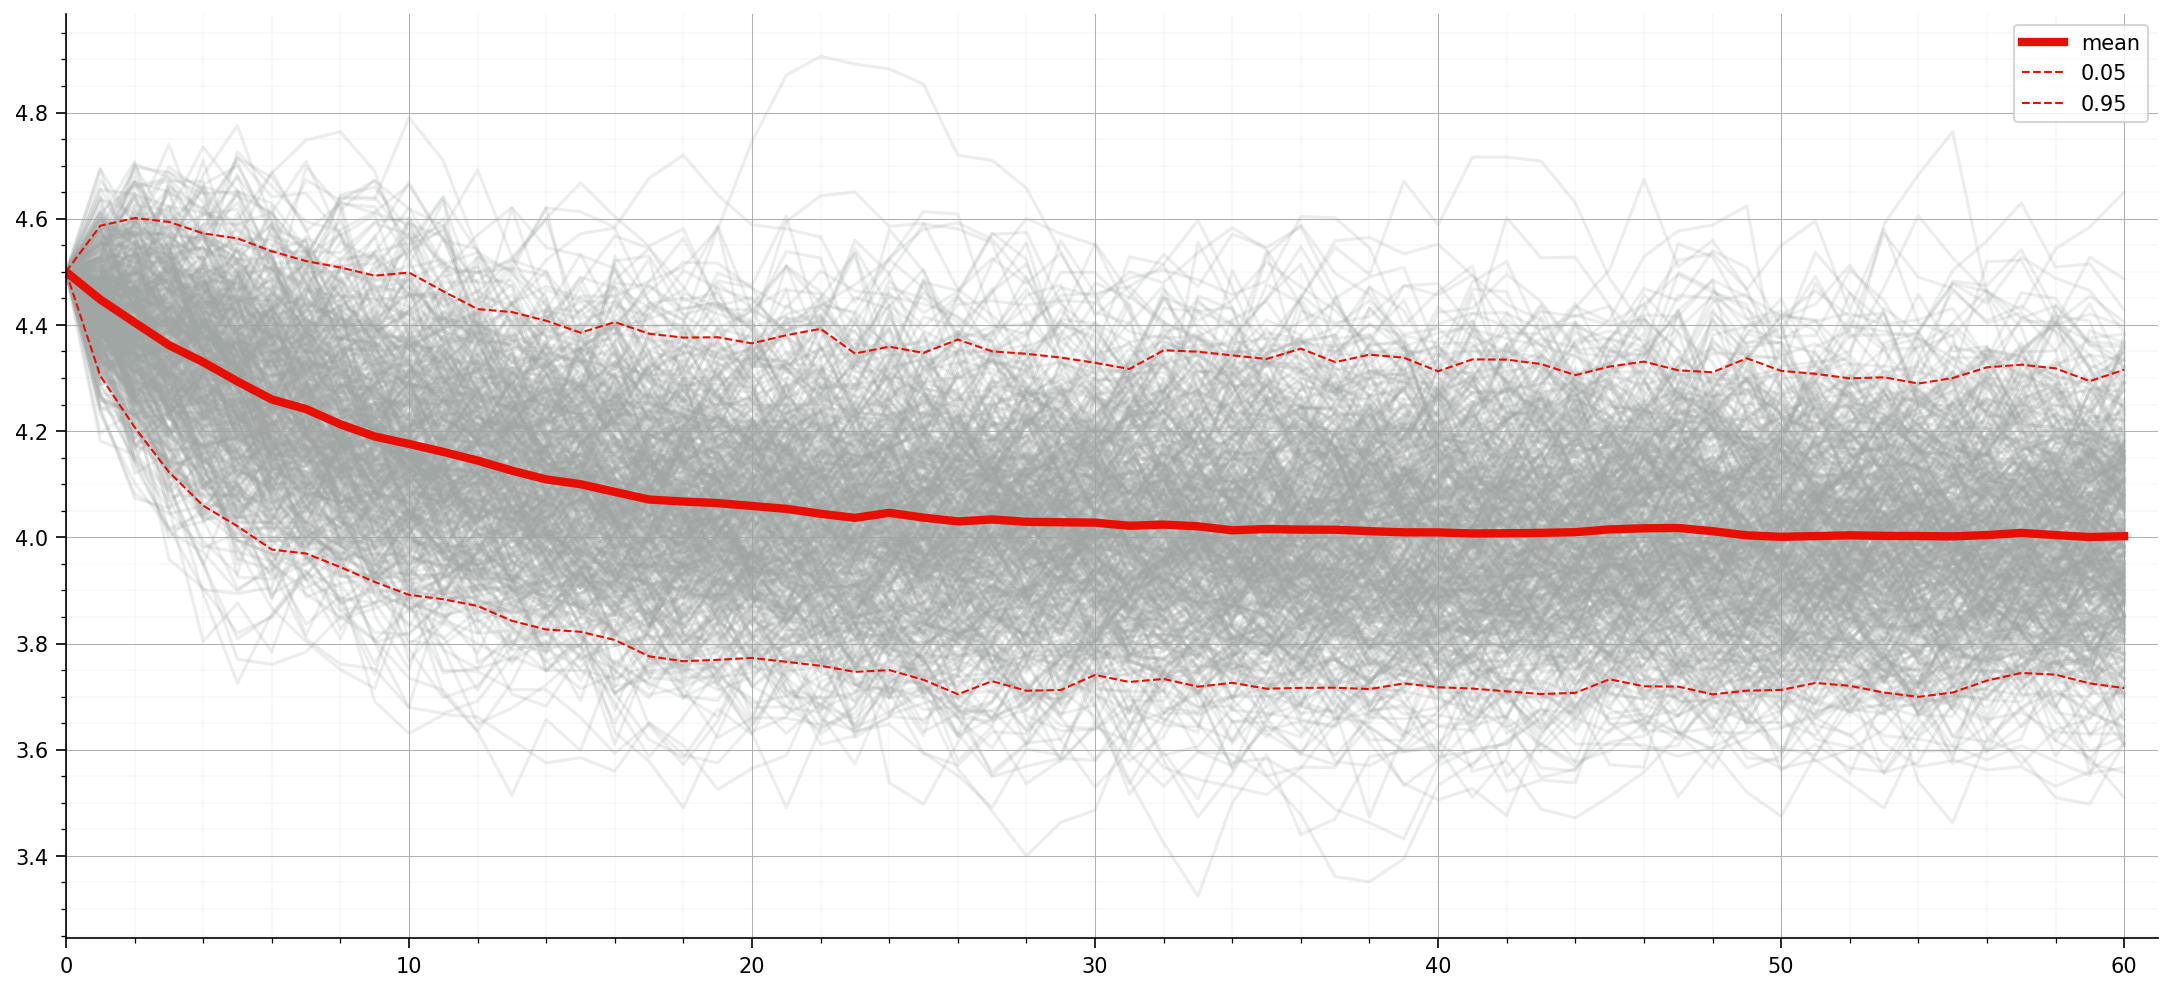

In [129]:
alpha = 0.1
theta = 4
sigma = 0.02
lambda_jump = 0.5
jump_mean = 0.05
jump_std = 0.01
jump_size = 0.05

n_steps = 60
n_paths = 500
dt = 1
r0 = 4.5

cir = DefaultCIR(
    alpha=alpha, 
    theta=theta, 
    sigma=sigma,
)
cir_paths = cir.get_simulated_paths(
    n_steps=n_steps, n_paths=n_paths, dt=dt, r0=r0
)
cir.plot_paths(cir_paths)

In [131]:
cir_paths.shape

(61, 500)

In [140]:
upper_bound = 4.4
lower_bound = 4
notional_payment = 10

In [134]:
future = cir_paths[1:]
future
future.shape

(60, 500)

In [142]:
(((future >= lower_bound) & (future <= upper_bound)).mean(axis=1) * notional_payment).sum()

328.84000000000003

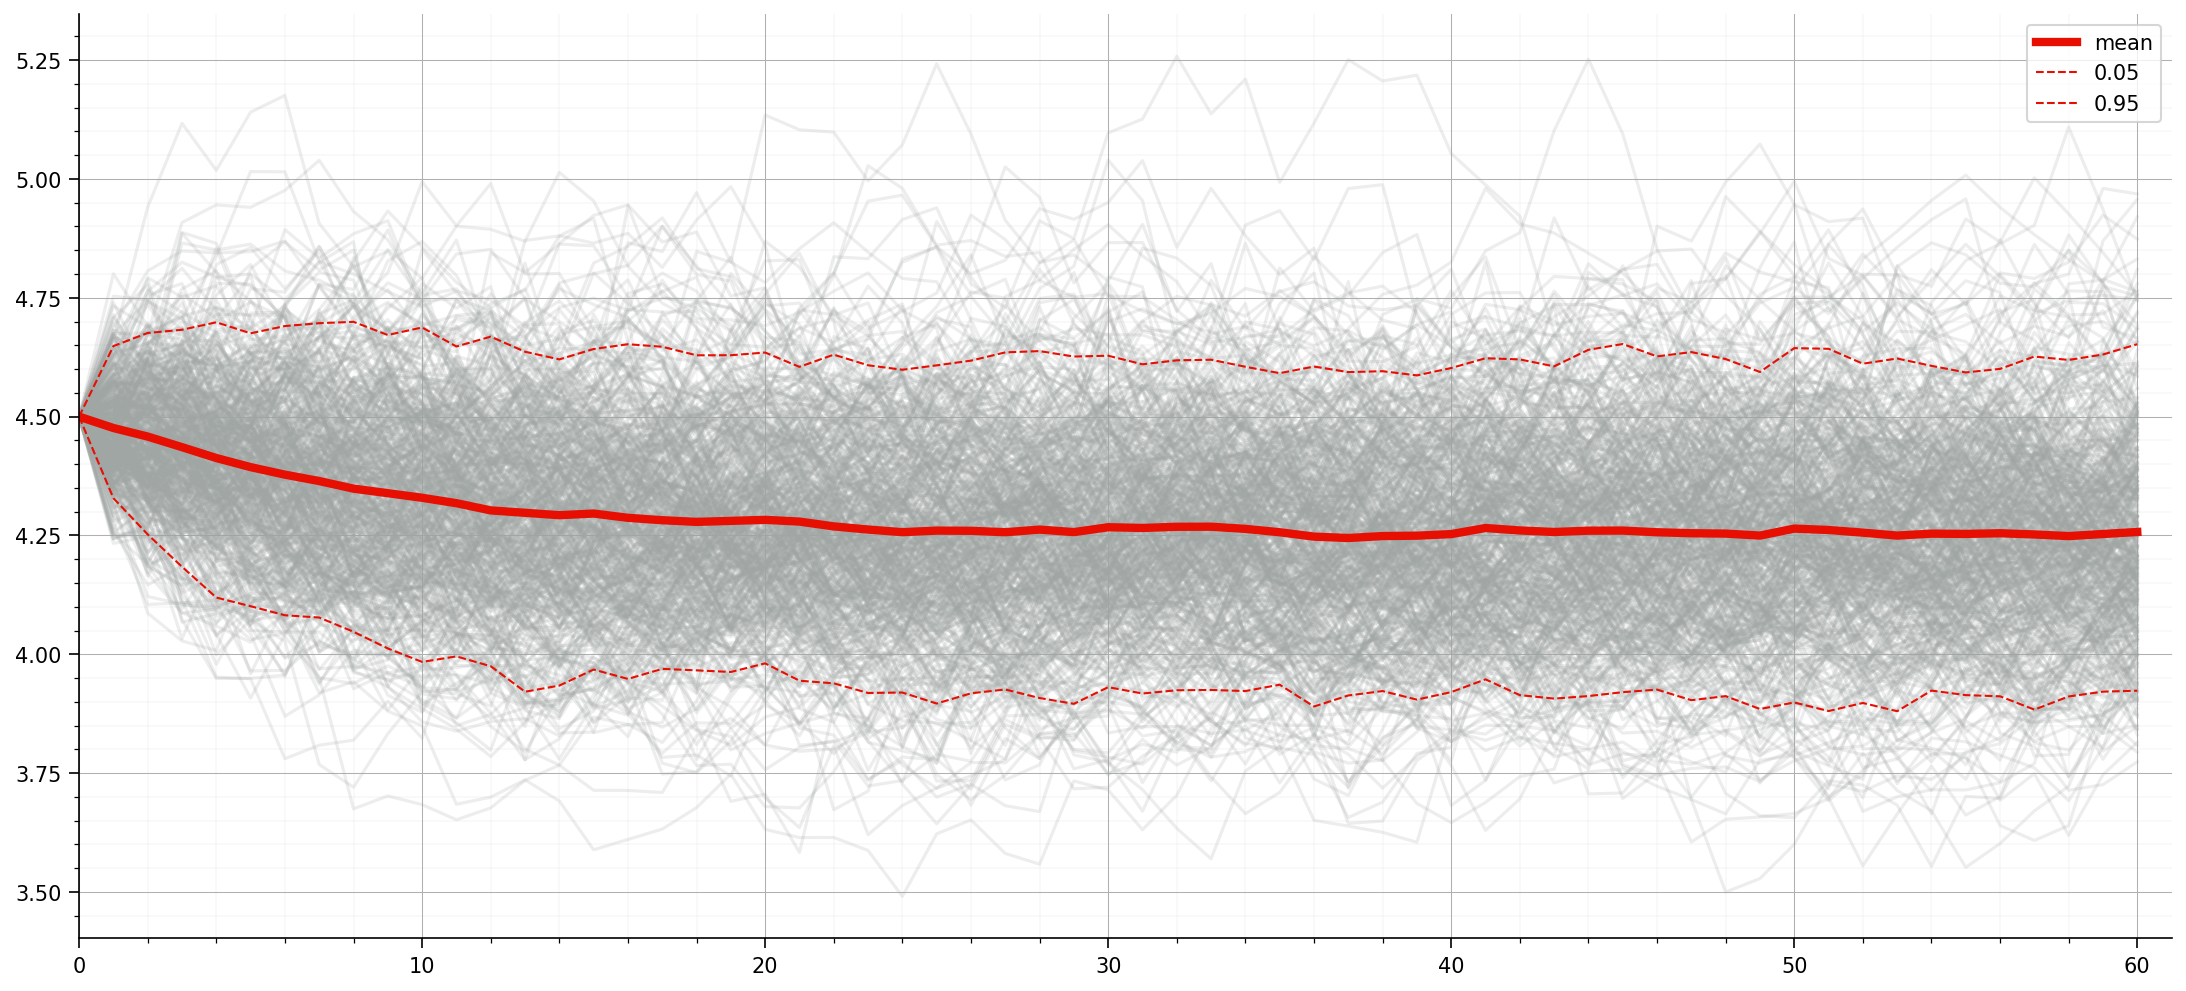

In [21]:
const_poisson = ConstPossionJumpsCIR(
    alpha=alpha, 
    theta=theta, 
    sigma=sigma,
    lambda_jump=lambda_jump,
    jump_size=jump_size,
)
const_poisson_paths = const_poisson.get_simulated_paths(
    n_steps=n_steps, n_paths=n_paths, dt=dt, r0=r0
)
const_poisson.plot_paths(const_poisson_paths)

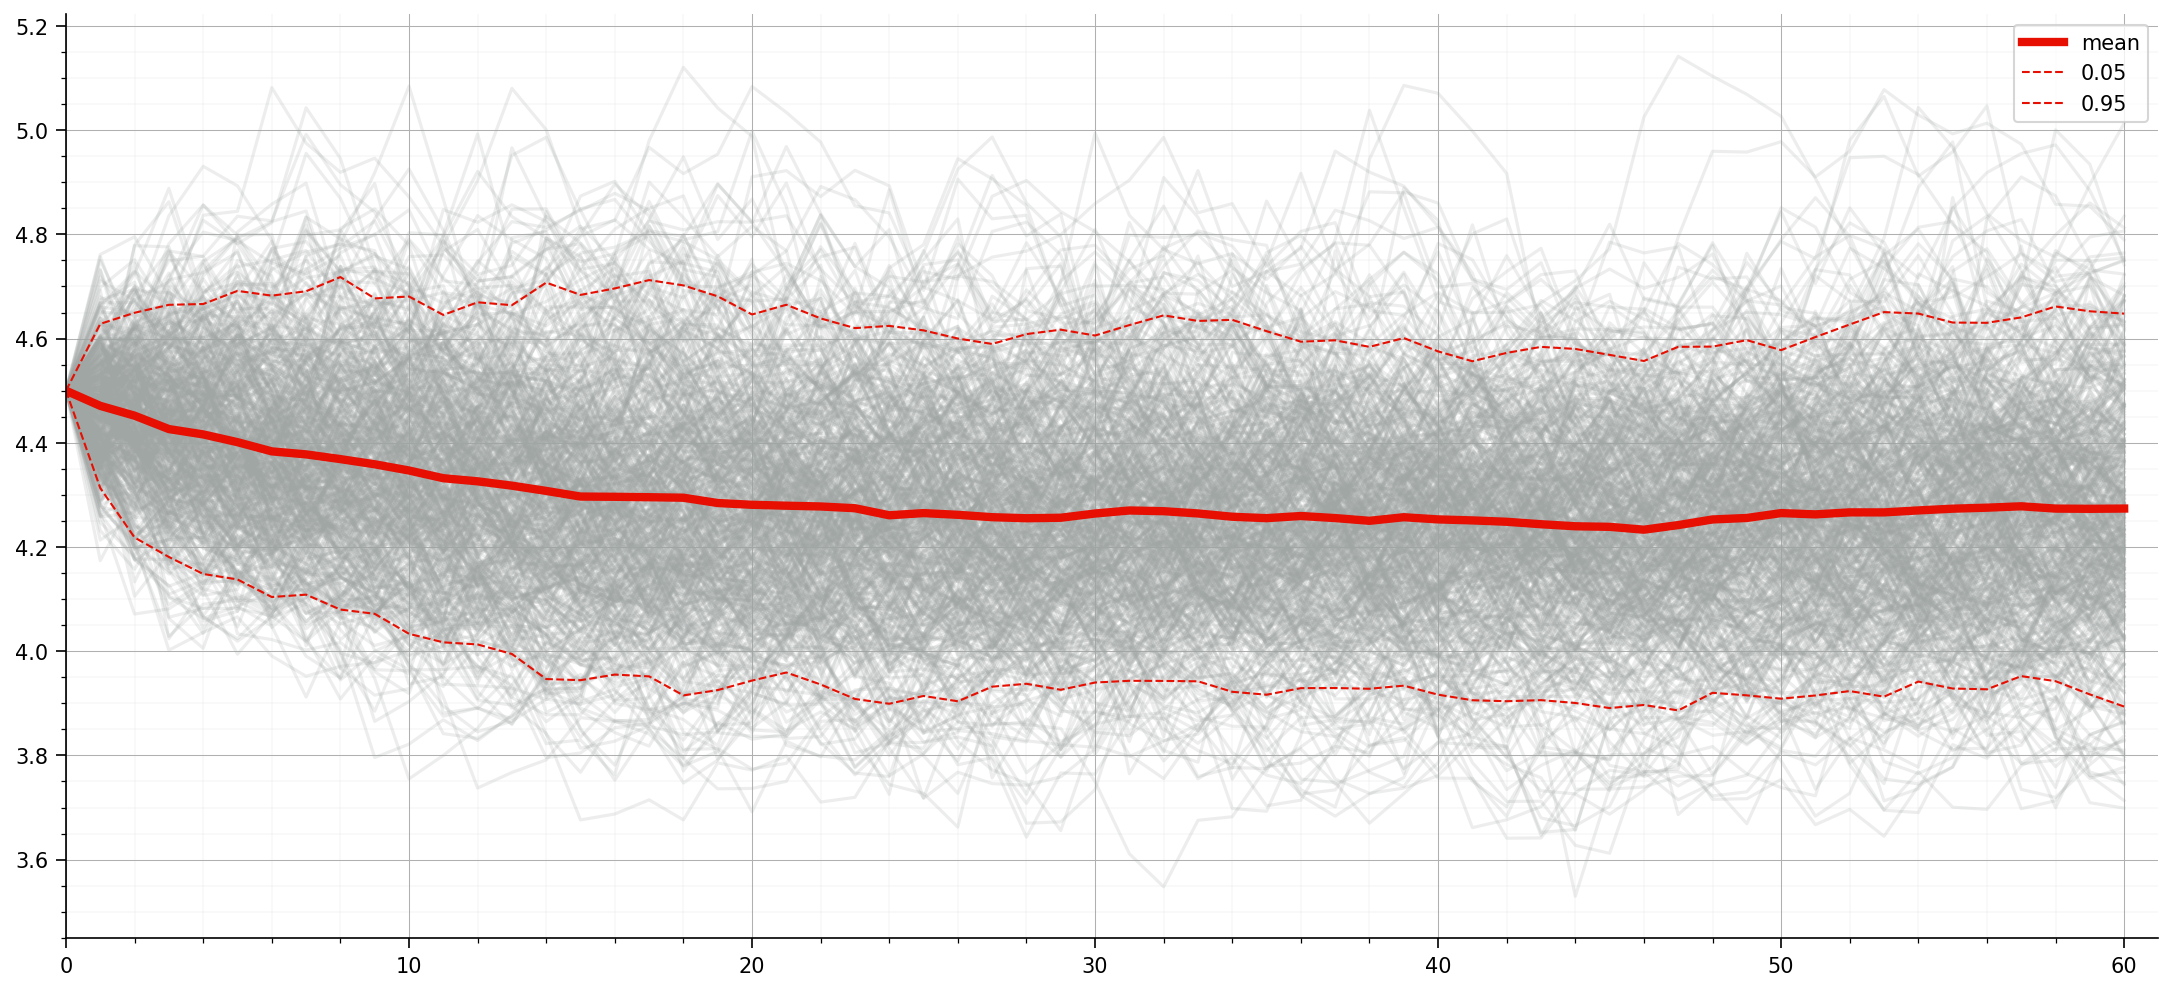

In [22]:
normal_poisson = NormalPossionJumpsCIR(
    alpha=alpha, 
    theta=theta, 
    sigma=sigma,
    lambda_jump=lambda_jump,
    jump_mean=jump_mean,
    jump_std=jump_std
)
normal_poisson_paths = normal_poisson.get_simulated_paths(
    n_steps=n_steps, n_paths=n_paths, dt=dt, r0=r0
)
normal_poisson.plot_paths(normal_poisson_paths)